In [142]:
%matplotlib inline
from scipy.spatial import distance 
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import os
from pytrackmate import trackmate_peak_import
from glob import glob
import pandas as pd
import numpy as np
import xml.etree.ElementTree as et
import seaborn as sns
import openpyxl
import re
import plotly.express as px
import sklearn.preprocessing as preprocessing
import dabest
from scipy.signal import correlate
from tqdm import tqdm
import time
import dabest
import plotly.graph_objects as go
from datetime import datetime
from scipy import stats

Format TrackMate Outputs for analysis:

In [5]:
# Load Trackmate xml files into a python dictionary with the following structure:
# tracks = {'0': {'nSpots': 20, 'trackData': numpy.array(t, x, y, z) }}
# Tracks should be xml file from 'Export tracks to XML file'

def loadxmlTrajs(xmlfile):
    try:
        tree = et.parse(xmlfile);
    except OSError:
        print('Failed to read XML file {}.'.format(xlmfile) )
    root =  tree.getroot()
    # print(root.attrib)  # or extract metadata
    nTracks = int(root.attrib['nTracks'])
    tracks = {}
    for i in range(nTracks):
        trackIdx = str(i)
        tracks[trackIdx] = {}
        nSpots = int(root[i].attrib['nSpots'])
        tracks[trackIdx]['nSpots'] = nSpots
        trackData = np.array([ ]).reshape(0, 4)
        for j in range(nSpots):
            t = float(root[i][j].attrib['t'])
            x = float(root[i][j].attrib['x'])
            y = float(root[i][j].attrib['y'])
            z = float(root[i][j].attrib['z'])
            spotData = np.array([t, x, y, z])
            trackData = np.vstack((trackData, spotData))
        tracks[trackIdx]['trackData'] = trackData
    return tracks

In [6]:
#calculate track MSD using FFT

def msd_calc_v1(r):
    shifts = np.arange(len(r))
    msds = np.zeros(shifts.size)    
    for i, shift in enumerate(shifts):
        diffs = r[:-shift if shift else None] - r[shift:]
        sqdist = np.square(diffs).sum(axis=1)
        msds[i] = sqdist.mean()
    return msds

def autocorrFFT(x):
    N=len(x)
    F = np.fft.fft(x, n=2*N)  #2*N because of zero-padding
    PSD = F * F.conjugate()
    res = np.fft.ifft(PSD)
    res= (res[:N]).real   #now we have the autocorrelation in convention B
    n=N*np.ones(N)-np.arange(0,N) #divide res(m) by (N-m)
    return res/n #this is the autocorrelation in convention A

def msd_fft(r):
    N=len(r)
    D=np.square(r).sum(axis=1) 
    D=np.append(D,0) 
    S2=sum([autocorrFFT(r[:, i]) for i in range(r.shape[1])])
    Q=2*D.sum()
    S1=np.zeros(N)
    for m in range(N):
        Q=Q-D[m-1]-D[N-m]
        S1[m]=Q/(N-m)
    return S1-2*S2

In [7]:
# calculate speed of trajectory. function takes a trajectory array and frame interval as arguments
# returns the instantaneous speed at each frame. Use .mean function to find average for cell

def Speed(trajectory_array, time_step):
    inst_spd=[]
    for i in range(1, len(trajectory_array)-1):
        # we are finding the euclidean distance between successive frame a and frame b
        a = np.array((trajectory_array[i][0], trajectory_array[i][1]))
        b = np.array((trajectory_array[i+1][0], trajectory_array[i+1][1]))
        dist = np.linalg.norm(a-b)
        #speed=distance/time, time_step is declared in the function
        speed = dist/time_step 
        #appends to list with the instaneous speed at each timepoint
        inst_spd.append(speed) 
    return inst_spd

In [8]:
# This function calculates the directionality ratio,  oft referred to as the straightness ratio
# aka straight-line length between start and the endpoint, divided by length of the trajectory
# function takes a array of coordinates (trajectory_array) and returns DF with Dir_Ratio at every
# point and the Dir_ratio at the last point of the movie

def Dir_Ratio(trajectory_array):
    all_dist=[]
    for i in range(len(trajectory_array)-1):
        #find frame a (i) and frame b (i+1)
        a = np.array((trajectory_array[i][0], trajectory_array[i][1]))
        b = np.array((trajectory_array[i+1][0], trajectory_array[i+1][1]))
        # calculate euclidean distance between successive frame a and frame b
        dist = np.linalg.norm(a-b) 
        # append distance of each frame to a list
        all_dist.append(dist) 

    cum_dist=[]
    dir_ratio=[]
    for i in range(len(all_dist)):
        # loop thru and iteratively add distances up to timepoint i into an empty list
        cum_dist.append(all_dist[i]) 
        # sum list to give the Dt (total trajectory length) up to timepoint i
        Dt_to_date = sum(cum_dist) 
        # calculate the straightline distance (dt) between frame 0 and frame i 
        a = np.array((trajectory_array[0][0], trajectory_array[0][1]))
        b = np.array((trajectory_array[i][0], trajectory_array[i][1]))
        dt_to_date = np.linalg.norm(a-b)
        # calculate directionality ratio: straightline dist (dt)/actual trajectory length Dt
        dir_ratio_now = dt_to_date/Dt_to_date
        dir_ratio.append(dir_ratio_now)
    # log the dir_ratio at the last frame of the trajectory 
    dir_ratio_lastpoint = dt_to_date/Dt_to_date
    return dir_ratio, dir_ratio_lastpoint

In [9]:
# This function performs direction (angle) autocorrelation analysis w/ overlapping time intervals

# User supply (1) coordinate list (trajectory_array) and (2) time interval btw frames (delta_t)
# Outputs  DataFrame of all Directional Autocorrelation coefficients. To average across multiple
# cells use weighted average function

# Framework adopted from Gorelik et al 2014 https://www.nature.com/articles/nprot.2014.131

def dir_auto(trajectory_array, delta_t):
    total_displacements = len(trajectory_array)-1

    track_pauses=[]
    vectors_list=[]

    for i in range(0, total_displacements):
        # For instances that a displacement vector cannot be generated aka if the cell stands in 
        # place we want to ignore those timepoints. One way to do this is by omitting any
        # 'missing' vectors. So we will find any instances where the trajectory does not change
        # x or y coordinates between timepoint i and i+1 and add them to an array for later.
        # these gaps become problematic if you lack a enough cells or have vv short trajectories
        if trajectory_array[i][0]==trajectory_array[i+1][0] and trajectory_array[i][1]==trajectory_array[i+1][1]:
            track_pauses.append(i)

        # Scan thru track dataframe and only find coordinates that move between frame a at  
        # time point i and B at time i+1
        else: 
            a = np.array((trajectory_array[i][0], trajectory_array[i][1]))
            b = np.array((trajectory_array[i+1][0], trajectory_array[i+1][1]))   

            # Find directional vector AB by subtracting starting point A from terminal point B
            vec_ab = b-a 
            vectors_list.append(vec_ab)

    # Normalize magnitude of our displacement vectors, this eliminates any bias from diff in speed
    norm_vecs = preprocessing.normalize(vectors_list, norm='l2')

    # Calculate angles (alpha) formed by each normalized vector
    alphas_list = []
    for i in range(len(norm_vecs)):
        # since alpha = tan–1(y/x) and we want from 0:360 degrees then:
        vec_alpha = np.arctan2(norm_vecs[i][1], norm_vecs[i][0])
        alphas_list.append(vec_alpha)

    # Add back in the pauses to our list of alphas for when we perform autocorrelation
    for i in track_pauses:
        alphas_list.insert(i, float('nan'))

    # step intervals though such that step interval 1 is cos(θ1,2), cos(θ2,3) etc. and
    # step interval 2 is cos(θ1,3), cos(θ2,4) etc. and step interval 3 is cos(θ1,4) etc.
    track_dir_auto = pd.DataFrame(columns =[])
    for stepsize in range(0, total_displacements):
        thetas=[]
        for i in range(total_displacements-stepsize):
        # If cell stops (ie btw t2 & t3) vector cannot be produced so we skip v for paused t
            if i in track_pauses or (i+stepsize) in track_pauses:
                thetas.append(float('nan'))
        # calculate angles θ between each step interval ie θ1,3=α1-α3 and calculates cosθ
            else:
                alpha_diff = np.cos(alphas_list[i]-alphas_list[i+stepsize])
                thetas.append(alpha_diff)
        step_dir_auto = pd.DataFrame(thetas, columns = [stepsize*delta_t])
        track_dir_auto = pd.concat([track_dir_auto, step_dir_auto], axis=1)
    return track_dir_auto

In [10]:
# This function performs normalized velocity autocorrelation analysis with overlapping time intervals
# Takes input as an array of coordinates (trajectory_array) and time interval between frames, delta_t

# Framework adopted from Gorelik et al 2014 https://www.nature.com/articles/nprot.2014.131

def vel_auto(trajectory_array, delta_t):
    total_displacements = len(trajectory_array)-1
    
    velocity_vectors_list = []
    Norm = 0
    for i in range(0, total_displacements-1):
        xProd = np.square(trajectory_array[i][0]-trajectory_array[i+1][0])
        yProd = np.square(trajectory_array[i][1]-trajectory_array[i+1][1])
        Norm = Norm+xProd+yProd
    Norm = Norm/(np.square(delta_t)*total_displacements)

    track_vel_auto = pd.DataFrame(columns =[])
    for stepsize in range(1, int((total_displacements-2)/3)):
        v_autocorr_n =[]
        for i in range(0, total_displacements-stepsize):
            xProd_1 = (np.array(trajectory_array[i][0])-np.array(trajectory_array[i+1][0]))
            xProd_2 = (np.array(trajectory_array[i+stepsize][0])-np.array(trajectory_array[i+stepsize+1][0]))
            xProd = xProd_1*xProd_2 
            yProd_1 = (np.array(trajectory_array[i][1])-np.array(trajectory_array[i+1][1]))
            yProd_2 = (np.array(trajectory_array[i+stepsize][1])-np.array(trajectory_array[i+stepsize+1][1]))
            yProd = yProd_1*yProd_2
            salsa = (xProd+yProd)/(Norm*np.square(delta_t))
            v_autocorr_n.append(salsa)
        step_vel_auto = pd.DataFrame(v_autocorr_n, columns = [stepsize*delta_t])

        track_vel_auto = pd.concat([track_vel_auto, step_vel_auto], axis=1)
    return track_vel_auto

In [11]:
def weighted_average(distrib, weights):
    top = sum([distrib[i]*weights[i] for i in range(len(distrib))])
    bot = sum(weights)
    return round(top/bot,2)

In [23]:
# This formats dataframe from trackmate and calculates

#save_name = '2021_12_17_Exp263_+Y1_TrackMate_Tracks'

# folder_path = "F:/Jesse/cKO/cKO_XML_Trajectories/cKO/"
# folder_path = "F:/Jesse/cKO/cKO_XML_Trajectories/Con(cKO)/"

# folder_path = "F:/Jesse/GoF/GoF_XML_Trajectories/GoF_tracks"
folder_path = "F:/Jesse/GoF/GoF_XML_Trajectories/Con_GoF_tracks"

# folder_path = "F:/Jesse/tdTomato+Drug/dmso_tracks/"
# folder_path = "F:/Jesse/tdTomato+Drug/yoda1_tracks/"

fname = sorted(glob(os.path.join(folder_path, "*.xml")))

all_msd_df = pd.DataFrame(columns =[])
all_speed_df = pd.DataFrame(columns =[])
all_dir_ratio_df = pd.DataFrame(columns =[])
dir_ratio_last = []

all_dir_auto = pd.DataFrame(columns =[])
all_vel_auto = pd.DataFrame(columns =[])

for file in tqdm(range(len(fname)), position=0, leave=True):
    file_name = fname[file].split('\\')[-1]
    file_name = re.sub('_ScratchFast','',file_name)
    file_name = re.sub('_MMStack','',file_name)
    file_name = re.sub('_Tracks.xml','',file_name)
    track_xml_file = loadxmlTrajs(fname[file])
    all_dataframe = pd.DataFrame.from_dict(track_xml_file)
    all_tracks_dataframe = pd.DataFrame(all_dataframe.loc['trackData'])
    for index, track_data in all_tracks_dataframe.iterrows():
        track_instance = all_tracks_dataframe.loc[index, 'trackData']
        track_df = pd.DataFrame(track_instance)
        
        # Convert trajectory coordinates from pixel to microns
        track_df[1] = track_df[1]*(0.6442*4) 
        track_df[2] = track_df[2]*(0.6442*4)
        track_df.drop([0, 3], axis=1, inplace=True)
        trajectory_array = track_df.to_numpy()
        
        # Calculate track directionality ratio
        track_dir_ratio, dir_ratio_lastpoint = Dir_Ratio(trajectory_array)
        dir_ratio_df = pd.DataFrame(track_dir_ratio, columns=[file_name+'_Track_'+index])
        all_dir_ratio_df = pd.concat([all_dir_ratio_df, dir_ratio_df], axis=1)
        dir_ratio_last.append(dir_ratio_lastpoint)
        
#         # Calculate track speed
        track_speed = Speed(trajectory_array, 5)
        speed_df = pd.DataFrame(track_speed, columns=[file_name+'_Track_'+index])
        all_speed_df = pd.concat([all_speed_df, speed_df], axis=1)
        
#         # Calculate track MSD
        track_MSD = msd_fft(trajectory_array)
        msd_df = pd.DataFrame(track_MSD, columns=[file_name+'_Track_'+index])
        all_msd_df = pd.concat([all_msd_df,msd_df], axis=1)
        
        # Calculate velocity correlation
        VelA = vel_auto(trajectory_array, 5)
        all_vel_auto = pd.concat([all_vel_auto, VelA], axis=0)
        
        # Calculate directional correlation
        DirrA = dir_auto(trajectory_array, 5)
        all_dir_auto = pd.concat([all_dir_auto, DirrA], axis=0)

100%|█████████████████████████████████████████████████████████████████████████████| 56/56 [15:50:31<00:00, 1346.71s/it]


In [24]:
#Prefixes= DMSO, Yoda1, Con_cKO, cKO, GoF, Con_GoF

Con_GoF_Speed_All = all_speed_df
Con_GoF_MSD_All = all_msd_df
Con_GoF_DirRatio_All = all_dir_ratio_df
Con_GoF_DirRatio_Last = dir_ratio_last

Con_GoF_DA = all_dir_auto
Con_GoF_VA = all_vel_auto



Export Python Outputs to CSV

In [ ]:
date = datetime.now().strftime("%Y_%m_%d_%I_%M_%p")

DMSO_Speed_All.to_csv(f'C:/Users/17605/Downloads/{date}_DMSO_Speed.csv')
Yoda1_Speed_All.to_csv(f'C:/Users/17605/Downloads/{date}_Yoda1_Speed.csv')
DMSO_MSD_All.to_csv(f'C:/Users/17605/Downloads/{date}_DMSO_MSD.csv')
Yoda1_MSD_All.to_csv(f'C:/Users/17605/Downloads/{date}_Yoda1_MSD.csv')

DMSO_DirRatio_All.to_csv(f'C:/Users/17605/Downloads{date}_DMSO_DirRatio.csv')
Yoda1_DirRatio_All.to_csv(f'C:/Users/17605/Downloads{date}_Yoda1_DirRatio.csv')

DMSO_DirRatio_Last.to_csv(f'C:/Users/17605/Downloads/{date}_DMSO_DirRatio_Last.csv')
Yoda1_DirRatio_Last.to_csv(f'C:/Users/17605/Downloads/{date}_Yoda1_DirRatio_Last.csv')

DMSO_DA.to_csv(f'C:/Users/17605/Downloads/{date}_DMSO_DA.csv')
Yoda1_DA.to_csv(f'C:/Users/17605/Downloads/{date}_Yoda1_DA.csv')

DMSO_VA.to_csv(f'C:/Users/17605/Downloads/{date}_DMSO_VA.csv')
Yoda1_VA.to_csv(f'C:/Users/17605/Downloads/{date}_Yoda1_VA.csv')

In [ ]:
date = datetime.now().strftime("%Y_%m_%d_%I_%M_%p")

Con_GoF_Speed_All.to_csv(f'C:/Users/17605/Downloads/{date}_Con_GoF_Speed.csv')
GoF_Speed_All.to_csv(f'C:/Users/17605/Downloads/{date}_GoF_Speed.csv')
Con_GoF_MSD_All.to_csv(f'C:/Users/17605/Downloads/{date}_Con_GoF_MSD.csv')
GoF_MSD_All.to_csv(f'C:/Users/17605/Downloads/{date}_GoF_MSD.csv')

Con_GoF_DirRatio_All.to_csv(f'C:/Users/17605/Downloads{date}_Con_GoF_DirRatio.csv')
GoF_DirRatio_All.to_csv(f'C:/Users/17605/Downloads{date}_GoF_DirRatio.csv')

# Con_GoF_DirRatio_Last.to_csv(f'C:/Users/17605/Downloads/{date}_Con_GoF_DirRatio_Last.csv')
# GoF_DirRatio_Last.to_csv(f'C:/Users/17605/Downloads/{date}_GoF_DirRatio_Last.csv')

Con_GoF_DA.to_csv(f'C:/Users/17605/Downloads/{date}_Con_GoF_DA.csv')
GoF_DA.to_csv(f'C:/Users/17605/Downloads/{date}_GoF_DA.csv')

Con_GoF_VA.to_csv(f'C:/Users/17605/Downloads/{date}_Con_GoF_VA.csv')
GoF_VA.to_csv(f'C:/Users/17605/Downloads/{date}_GoF_VA.csv')

In [ ]:
date = datetime.now().strftime("%Y_%m_%d_%I_%M_%p")

# Con_cKO_Speed_All.to_csv(f'C:/Users/17605/Downloads/{date}_Con_cKO_Speed.csv')
# cKO_Speed_All.to_csv(f'C:/Users/17605/Downloads/{date}_cKO_Speed.csv')
# Con_cKO_MSD_All.to_csv(f'C:/Users/17605/Downloads/{date}_Con_cKO_MSD.csv')
# cKO_MSD_All.to_csv(f'C:/Users/17605/Downloads/{date}_cKO_MSD.csv')

# Con_cKO_DirRatio_All.to_csv(f'C:/Users/17605/Downloads{date}_Con_cKO_DirRatio.csv')
# cKO_DirRatio_All.to_csv(f'C:/Users/17605/Downloads{date}_cKO_DirRatio.csv')

# Con_cKO_DirRatio_Last.to_csv(f'C:/Users/17605/Downloads/{date}_Con_cKO_DirRatio_Last.csv')
# cKO_DirRatio_Last.to_csv(f'C:/Users/17605/Downloads/{date}_cKO_DirRatio_Last.csv')

Con_cKO_DA.to_csv(f'C:/Users/17605/Downloads/{date}_Con_cKO_DA.csv')
# cKO_DA.to_csv(f'C:/Users/17605/Downloads/{date}_cKO_DA.csv')

Con_cKO_VA.to_csv(f'C:/Users/17605/Downloads/{date}_Con_cKO_VA.csv')
# cKO_VA.to_csv(f'C:/Users/17605/Downloads/{date}_cKO_VA.csv')

Read CSVs and setup for graphing functions

In [192]:
DMSO_MSD = pd.read_csv ("2022_04_16_07_32_AM_DMSO_MSD.csv")
Yoda1_MSD = pd.read_csv ("2022_04_16_07_32_AM_Yoda1_MSD.csv")
Con_GoF_MSD = pd.read_csv ("2022_04_19_06_42_AM_Con_GoF_MSD.csv")
GoF_MSD = pd.read_csv ("2022_04_19_06_42_AM_GoF_MSD.csv")
Con_cKO_MSD = pd.read_csv ("2022_04_12_07_17_AM_Con_cKO_MSD.csv")
cKO_MSD = pd.read_csv ("2022_04_12_07_17_AM_cKO_MSD.csv")

In [193]:
del DMSO_MSD['Unnamed: 0']
del Yoda1_MSD['Unnamed: 0']
del Con_GoF_MSD['Unnamed: 0']
del GoF_MSD['Unnamed: 0']
del Con_cKO_MSD['Unnamed: 0']
del cKO_MSD['Unnamed: 0']

In [39]:
All_MSD = pd.concat([pd.DataFrame(DMSO_MSD.mean(axis=1), columns=['DMSO_MSD_Mean']), 
                    pd.DataFrame(DMSO_MSD.sem(axis=1), columns=['DMSO_MSD_SEM']), 
                    pd.DataFrame(Yoda1_MSD.mean(axis=1), columns=['Yoda1_MSD_Mean']), 
                    pd.DataFrame(Yoda1_MSD.sem(axis=1), columns=['Yoda1_MSD_SEM']), 
                    pd.DataFrame(Con_cKO_MSD.mean(axis=1), columns=['Con(cKO)_MSD_Mean']), 
                    pd.DataFrame(Con_cKO_MSD.sem(axis=1), columns=['Con(cKO)_MSD_SEM']), 
                    pd.DataFrame(cKO_MSD.mean(axis=1), columns=['cKO_MSD_Mean']), 
                    pd.DataFrame(cKO_MSD.sem(axis=1), columns=['cKO_MSD_SEM']), 
                    pd.DataFrame(Con_GoF_MSD.mean(axis=1), columns=['Con(GoF)_MSD_Mean']), 
                    pd.DataFrame(Con_GoF_MSD.sem(axis=1), columns=['Con(GoF)_MSD_SEM']), 
                    pd.DataFrame(GoF_MSD.mean(axis=1), columns=['GoF_MSD_Mean']),  
                    pd.DataFrame(GoF_MSD.sem(axis=1), columns=['GoF_MSD_SEM'])], axis=1)

In [40]:
date = datetime.now().strftime("%Y_%m_%d_%I_%M_%p")

All_MSD.to_excel(f'{date}_All_MSD_mean_sem.xlsx')

In [127]:
DMSO_Speed = pd.read_csv ("2022_04_16_07_32_AM_DMSO_Speed.csv")
Yoda1_Speed = pd.read_csv ("2022_04_16_07_32_AM_Yoda1_Speed.csv")
Con_GoF_Speed = pd.read_csv ("2022_04_19_06_42_AM_Con_GoF_Speed.csv")
GoF_Speed = pd.read_csv ("2022_04_19_06_42_AM_GoF_Speed.csv")
Con_cKO_Speed = pd.read_csv ("2022_04_12_07_17_AM_Con_cKO_Speed.csv")
cKO_Speed = pd.read_csv ("2022_04_12_07_17_AM_cKO_Speed.csv")

In [ ]:
del DMSO_Speed['Unnamed: 0']
del Yoda1_Speed['Unnamed: 0']
del Con_GoF_Speed['Unnamed: 0']
del GoF_Speed['Unnamed: 0']
del Con_cKO_Speed['Unnamed: 0']
del cKO_Speed['Unnamed: 0']

In [44]:
DMSO_Speed_Stack = pd.melt(DMSO_Speed, var_name='DMSO Filename', value_name='DMSO Speed (um/min)')
DMSO_Speed_Stack.dropna(inplace=True)
Yoda1_Speed_Stack = pd.melt(Yoda1_Speed, var_name='Yoda1 Filename', value_name='Yoda1 Speed (um/min)')
Yoda1_Speed_Stack.dropna(inplace=True)
Con_GoF_Speed_Stack = pd.melt(Con_GoF_Speed, var_name='Con(GoF) Filename', value_name='Con(GoF)Speed (um/min)')
Con_GoF_Speed_Stack.dropna(inplace=True)
GoF_Speed_Stack = pd.melt(GoF_Speed, var_name='GoF Filename', value_name='GoF Speed (um/min)')
GoF_Speed_Stack.dropna(inplace=True)
Con_cKO_Speed_Stack = pd.melt(Con_cKO_Speed, var_name='Con(cKO) Filename', value_name='Con(cKO) Speed (um/min)')
Con_cKO_Speed_Stack.dropna(inplace=True)
cKO_Speed_Stack = pd.melt(cKO_Speed, var_name='cKO Filename', value_name='cKO Speed (um/min)')
cKO_Speed_Stack.dropna(inplace=True)

In [45]:
All_Speed =pd.concat([pd.DataFrame(DMSO_Speed_Stack['DMSO Speed (um/min)']),
            pd.DataFrame(Yoda1_Speed_Stack['Yoda1 Speed (um/min)']),
            pd.DataFrame(Con_GoF_Speed_Stack['Con(GoF)Speed (um/min)']),
            pd.DataFrame(GoF_Speed_Stack['GoF Speed (um/min)']),
            pd.DataFrame(Con_cKO_Speed_Stack['Con(cKO) Speed (um/min)']),
            pd.DataFrame(cKO_Speed_Stack['cKO Speed (um/min)'])], 
            axis=1, 
            ignore_index=True)
All_Speed.rename(columns = {0: 'DMSO', 1:'Yoda1', 2:'Con(GoF)', 3:'GoF', 4:'Con(cKO)', 5:'cKO'}, inplace=True)

date = datetime.now().strftime("%Y_%m_%d_%I_%M_%p")

All_Speed.to_csv(f'{date}_All_Speed.csv')

In [116]:
dmso_speed_mean = pd.DataFrame(DMSO_Speed.mean(axis=0))
dmso_speed_mean.reset_index(inplace=True)
dmso_speed_mean.rename(columns={'index':'Filename', 0:"DMSO Speed (um/min)"}, inplace=True)
yoda1_speed_mean = pd.DataFrame(Yoda1_Speed.mean(axis=0))
yoda1_speed_mean.reset_index(inplace=True)
yoda1_speed_mean.rename(columns={'index':'Filename', 0:"Yoda1 Speed (um/min)"}, inplace=True)
con_cko_speed_mean = pd.DataFrame(Con_cKO_Speed.mean(axis=0))
con_cko_speed_mean.reset_index(inplace=True)
con_cko_speed_mean.rename(columns={'index':'Filename', 0:"Con(cKO) Speed (um/min)"}, inplace=True)
con_gof_speed_mean = pd.DataFrame(Con_GoF_Speed.mean(axis=0))
con_gof_speed_mean.reset_index(inplace=True)
yoda1_speed_mean.rename(columns={'index':'Filename', 0:"Con(GoF) Speed (um/min)"}, inplace=True)
cko_speed_mean = pd.DataFrame(cKO_Speed.mean(axis=0))
cko_speed_mean.reset_index(inplace=True)
cko_speed_mean.rename(columns={'index':'Filename', 0:"cKO Speed (um/min)"}, inplace=True)
gof_speed_mean = pd.DataFrame(GoF_Speed.mean(axis=0))
gof_speed_mean.reset_index(inplace=True)
gof_speed_mean.rename(columns={'index':'Filename', 0:"GoF Speed (um/min)"}, inplace=True)

All_Speed_Means =pd.concat([dmso_speed_mean,
            yoda1_speed_mean,
            con_cko_speed_mean,
            cko_speed_mean,
            con_gof_speed_mean,
            gof_speed_mean], 
            axis=1)

date = datetime.now().strftime("%Y_%m_%d_%I_%M_%p")

All_Speed_Means.to_excel(f'{date}_All_Speed_Means.xlsx')

In [ ]:
DMSO_Speed_Stack = pd.melt(DMSO_Speed.mean(axis=0), var_name='DMSO Filename', value_name='DMSO Speed (um/min)')
DMSO_Speed_Stack.dropna(inplace=True)
Yoda1_Speed_Stack = pd.melt(Yoda1_Speed.mean(axis=0), var_name='Yoda1 Filename', value_name='Yoda1 Speed (um/min)')
Yoda1_Speed_Stack.dropna(inplace=True)
Con_GoF_Speed_Stack = pd.melt(Con_GoF_Speed.mean(axis=0), var_name='Con(GoF) Filename', value_name='Con(GoF)Speed (um/min)')
Con_GoF_Speed_Stack.dropna(inplace=True)
GoF_Speed_Stack = pd.melt(GoF_Speed.mean(axis=0), var_name='GoF Filename', value_name='GoF Speed (um/min)')
GoF_Speed_Stack.dropna(inplace=True)
Con_cKO_Speed_Stack = pd.melt(Con_cKO_Speed.mean(axis=0), var_name='Con(cKO) Filename', value_name='Con(cKO) Speed (um/min)')
Con_cKO_Speed_Stack.dropna(inplace=True)
cKO_Speed_Stack = pd.melt(cKO_Speed.mean(axis=0), var_name='cKO Filename', value_name='cKO Speed (um/min)')
cKO_Speed_Stack.dropna(inplace=True)

In [45]:
DMSO_VA = pd.read_csv ("2022_04_16_07_32_AM_DMSO_VA.csv")
Yoda1_VA = pd.read_csv ("2022_04_16_07_32_AM_Yoda1_VA.csv")
Con_GoF_VA = pd.read_csv ("2022_04_19_06_42_AM_Con_GoF_VA.csv")
GoF_VA = pd.read_csv ("2022_04_19_06_42_AM_GoF_VA.csv")
Con_cKO_VA = pd.read_csv ("2022_04_14_05_39_PM_Con_cKO_VA.csv")
cKO_VA = pd.read_csv ("2022_04_12_07_33_AM_cKO_VA.csv")

In [46]:
DMSO_DA = pd.read_csv ("2022_04_16_07_32_AM_DMSO_DA.csv")
Yoda1_DA = pd.read_csv ("2022_04_16_07_32_AM_Yoda1_DA.csv")
Con_GoF_DA = pd.read_csv ("2022_04_19_06_42_AM_Con_GoF_DA.csv")
GoF_DA = pd.read_csv ("2022_04_19_06_42_AM_GoF_DA.csv")
Con_cKO_DA = pd.read_csv ("2022_04_14_05_39_PM_Con_cKO_DA.csv")
cKO_DA = pd.read_csv ("2022_04_12_07_33_AM_cKO_DA.csv")

In [56]:
del DMSO_VA['Unnamed: 0']
del Yoda1_VA['Unnamed: 0']
del Con_GoF_VA['Unnamed: 0']
del GoF_VA['Unnamed: 0']
del Con_cKO_VA['Unnamed: 0']
del cKO_VA['Unnamed: 0'] 

In [69]:
del DMSO_DA['Unnamed: 0']
del Yoda1_DA['Unnamed: 0']
del Con_GoF_DA['Unnamed: 0']
del GoF_DA['Unnamed: 0']
del Con_cKO_DA['Unnamed: 0']
del cKO_DA['Unnamed: 0'] 

In [73]:
All_DA = pd.concat([pd.DataFrame(DMSO_DA.mean(axis=0), columns=['DMSO_DA_Mean']), 
                    pd.DataFrame(DMSO_DA.sem(axis=0), columns=['DMSO_DA_SEM']), 
                    pd.DataFrame(Yoda1_DA.mean(axis=0), columns=['Yoda1_DA_Mean']), 
                    pd.DataFrame(Yoda1_DA.sem(axis=0), columns=['Yoda1_DA_SEM']), 
                    pd.DataFrame(Con_cKO_DA.mean(axis=0), columns=['Con(cKO)_DA_Mean']), 
                    pd.DataFrame(Con_cKO_DA.sem(axis=0), columns=['Con(cKO)_DA_SEM']), 
                    pd.DataFrame(cKO_DA.mean(axis=0), columns=['cKO_DA_Mean']), 
                    pd.DataFrame(cKO_DA.sem(axis=0), columns=['cKO_DA_SEM']), 
                    pd.DataFrame(Con_GoF_DA.mean(axis=0), columns=['Con(GoF)_DA_Mean']), 
                    pd.DataFrame(Con_GoF_DA.sem(axis=0), columns=['Con(GoF)_DA_SEM']), 
                    pd.DataFrame(GoF_DA.mean(axis=0), columns=['GoF_DA_Mean']),  
                    pd.DataFrame(GoF_DA.sem(axis=0), columns=['GoF_DA_SEM'])], axis=1)

All_VA = pd.concat([pd.DataFrame(DMSO_VA.mean(axis=0), columns=['DMSO_VA_Mean']), 
                    pd.DataFrame(DMSO_VA.sem(axis=0), columns=['DMSO_VA_SEM']), 
                    pd.DataFrame(Yoda1_VA.mean(axis=0), columns=['Yoda1_VA_Mean']), 
                    pd.DataFrame(Yoda1_VA.sem(axis=0), columns=['Yoda1_VA_SEM']), 
                    pd.DataFrame(Con_cKO_VA.mean(axis=0), columns=['Con(cKO)_VA_Mean']), 
                    pd.DataFrame(Con_cKO_VA.sem(axis=0), columns=['Con(cKO)_VA_SEM']), 
                    pd.DataFrame(cKO_VA.mean(axis=0), columns=['cKO_VA_Mean']),  
                    pd.DataFrame(cKO_VA.sem(axis=0), columns=['cKO_VA_SEM']), 
                    pd.DataFrame(Con_GoF_VA.mean(axis=0), columns=['Con(GoF)_VA_Mean']), 
                    pd.DataFrame(Con_GoF_VA.sem(axis=0), columns=['Con(GoF)_VA_SEM']), 
                    pd.DataFrame(GoF_VA.mean(axis=0), columns=['GoF_VA_Mean']), 
                    pd.DataFrame(GoF_VA.sem(axis=0), columns=['GoF_VA_SEM'])], axis=1)

date = datetime.now().strftime("%Y_%m_%d_%I_%M_%p")

All_DA.to_excel(f'{date}_All_DA_mean_sem.xls')
All_VA.to_excel(f'{date}_All_VA_mean_sem.xls')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and th

In [ ]:
dir_ratio_last = []
for (columnName, columnData) in Con_GoF_DirRatio_All.iteritems():
    taco = columnData.last_valid_index()
    dir_ratio_last.append(columnData[taco])

Stats

In [178]:
#define cohens d using the function defined here: https://machinelearningmastery.com/effect-size-measures-in-python/
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.nanmean(d1), np.nanmean(d2)
    # calculate the effect size
    return (u2 - u1) / s

In [196]:
cKO_msd_anova = []
for col in range(np.shape(cKO_MSD.transpose())[1]):
    stat, p = stats.f_oneway(Con_cKO_MSD.transpose()[col], cKO_MSD.transpose()[col])
    d = cohend(Con_cKO_MSD.transpose()[col], cKO_MSD.transpose()[col])
    cKO_msd_anova.append([stat, p, d])

date = datetime.now().strftime("%Y_%m_%d_")
cKO_Con_stats = pd.DataFrame(cKO_msd_anova, columns= ['ANOVA stat', 'ANOVA p', 'Cohens d'])
cKO_Con_stats.to_excel(f'{date}_cKOvCon_MSD_Stats.xlsx')

In [199]:
GoF_msd_anova = []
for col in range(np.shape(Con_GoF_MSD.transpose())[1]):
    stat, p = stats.f_oneway(Con_GoF_MSD.transpose()[col], GoF_MSD.transpose()[col])
    d = cohend(Con_GoF_MSD.transpose()[col], GoF_MSD.transpose()[col])
    GoF_msd_anova.append([stat, p, d])

date = datetime.now().strftime("%Y_%m_%d_")
GoF_Con_stats = pd.DataFrame(GoF_msd_anova, columns= ['ANOVA stat', 'ANOVA p', 'Cohens d'])
GoF_Con_stats.to_excel(f'{date}_GoFvCon_MSD_Stats.xlsx')

In [200]:
dmso_msd_anova = []
for col in range(np.shape(DMSO_MSD.transpose())[1]):
    stat, p = stats.f_oneway(DMSO_MSD.transpose()[col], Yoda1_MSD.transpose()[col])
    d=cohend(DMSO_MSD.transpose()[col], Yoda1_MSD.transpose()[col])
    dmso_msd_anova.append([stat, p, d])

date = datetime.now().strftime("%Y_%m_%d_")
dmso_y1_stats = pd.DataFrame(dmso_msd_anova, columns= ['ANOVA stat', 'ANOVA p', 'Cohens d'])
dmso_y1_stats.to_excel(f'{date}_DMSOvYoda1_MSD_Stats.xlsx')

In [213]:
dmso_VA_anova = []
for col in DMSO_VA:
    stat, p = stats.f_oneway(DMSO_VA[col], Yoda1_VA[col])
    d = cohend(DMSO_VA[col], Yoda1_VA[col])
    dmso_VA_anova.append([stat, p, d])

date = datetime.now().strftime("%Y_%m_%d_")
dmso_y1_VA_stats = pd.DataFrame(dmso_VA_anova, columns= ['ANOVA stat', 'ANOVA p', 'Cohens d'])
dmso_y1_VA_stats.to_excel(f'{date}_DMSOvYoda1_VA_Stats.xlsx')

In [247]:
cKO_VA_anova=[]
for count, col in enumerate(cKO_VA.columns):
    stat, p = stats.f_oneway(Con_cKO_VA[col], cKO_VA[col])
    d = cohend(Con_cKO_VA[col], cKO_VA[col])
    cKO_VA_anova.append([stat, p, d])

date = datetime.now().strftime("%Y_%m_%d_")
con_cko_VA_stats = pd.DataFrame(cKO_VA_anova, columns= ['ANOVA stat', 'ANOVA p', 'Cohens d'])
con_cko_VA_stats.to_excel(f'{date}_Con_cKO_VA_Stats.xlsx')

In [237]:
GoF_VA_anova=[]
for count, col in enumerate(Con_GoF_VA.columns):
    stat, p = stats.f_oneway(Con_GoF_VA[col], GoF_VA[col])
    d = cohend(Con_GoF_VA[col], GoF_VA[col])
    GoF_VA_anova.append([stat, p, d])

date = datetime.now().strftime("%Y_%m_%d_")
con_GoF_VA_stats = pd.DataFrame(GoF_VA_anova, columns= ['ANOVA stat', 'ANOVA p', 'Cohens d'])
con_GoF_VA_stats.to_excel(f'{date}_Con_GoF_VA_Stats.xlsx')

In [238]:
dmso_DA_anova=[]
for count, col in enumerate(DMSO_DA.columns):
    stat, p = stats.f_oneway(DMSO_DA[col], Yoda1_DA[col])
    d = cohend(DMSO_DA[col], Yoda1_DA[col])
    dmso_DA_anova.append([stat, p, d])

date = datetime.now().strftime("%Y_%m_%d_")
dmso_y1_DA_stats = pd.DataFrame(dmso_DA_anova, columns= ['ANOVA stat', 'ANOVA p', 'Cohens d'])
dmso_y1_DA_stats.to_excel(f'{date}_DMSOvYoda1_DA_Stats.xlsx')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


In [243]:
cKO_DA_anova=[]
for count, col in enumerate(cKO_DA.columns):
    stat, p = stats.f_oneway(Con_cKO_DA[col], cKO_DA[col])
    d = cohend(Con_cKO_DA[col], cKO_DA[col])
    cKO_DA_anova.append([stat, p, d])

date = datetime.now().strftime("%Y_%m_%d_")
con_cko_DA_stats = pd.DataFrame(cKO_DA_anova, columns= ['ANOVA stat', 'ANOVA p', 'Cohens d'])
con_cko_DA_stats.to_excel(f'{date}_Con_cKO_DA_Stats.xlsx')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


In [244]:
GoF_DA_anova=[]
for count, col in enumerate(Con_GoF_DA.columns):
    stat, p = stats.f_oneway(Con_GoF_DA[col], GoF_DA[col])
    d = cohend(Con_GoF_DA[col], GoF_DA[col])
    GoF_DA_anova.append([stat, p, d])

date = datetime.now().strftime("%Y_%m_%d_")
con_GoF_DA_stats = pd.DataFrame(GoF_DA_anova, columns= ['ANOVA stat', 'ANOVA p', 'Cohens d'])
con_GoF_DA_stats.to_excel(f'{date}_Con_GoF_DA_Stats.xlsx')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


DMSO v Yoda1 Figures & Stats

In [117]:
Con_Speed = pd.DataFrame(DMSO_Speed.mean(axis=0)).rename(columns={0:"DMSO"})
Test_Speed = pd.DataFrame(Yoda1_Speed.mean(axis=0)).rename(columns={0:"Yoda1"})
Speed_Pair = pd.concat([Con_Speed["DMSO"], Test_Speed["Yoda1"]], axis=1)
GoF_unpaired_speed = dabest.load(Speed_Pair, idx=("DMSO", "Yoda1"), resamples=5000)
GoF_unpaired_speed.cohens_d

DABEST v0.3.1
             
Good afternoon!
The current time is Thu Apr 21 13:16:23 2022.

The unpaired Cohen's d between DMSO and Yoda1 is -0.549 [95%CI -0.57, -0.527].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cohens_d.statistical_tests`

In [121]:
two_groups_unpaired.cohens_d.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,DMSO,Yoda1,13338,14012,Cohen's d,False,-0.549071,95,-0.570292,-0.527205,0.0,0.0,44.918943,0.0,45.388441,0.0,123079537.0


In [ ]:
dmso_y1_speed_fig = px.violin(df_Speed_Pair, box=True)
dmso_y1_speed_fig.show()

In [85]:
DirRatio_Last = pd.DataFrame([DMSO_DirRatio, Yoda1_DirRatio_Last])
DirRatio_Last = DirRatio_Last.transpose()
DirRatio_Last.rename(columns={0:"DMSO", 1:"Yoda1"},inplace=True)
DirRatio_Last_unpaired = dabest.load(DirRatio_Last, idx=("DMSO", "Yoda1"), resamples=5000)
DirRatio_Last_unpaired.cohens_d

DABEST v0.3.1
             
Good morning!
The current time is Wed Mar  2 11:39:45 2022.

The unpaired Cohen's d between DMSO and Yoda1 is -0.249 [95%CI -0.289, -0.207].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cohens_d.statistical_tests`

In [86]:
DirRatio_Last_unpaired.cohens_d.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,DMSO,Yoda1,4689,4167,Cohen's d,False,-0.249491,95,-0.288924,-0.206539,0.0,3.443792e-32,11.857869,1.740252e-31,11.718935,3.022438e-21,10905812.0


In [ ]:
dmso_y1_DirRatioLast_fig = px.violin(DirRatio_Last, box=True)
dmso_y1_DirRatioLast_fig.show()

In [ ]:
time=[]
for i in range(len(DMSO_DirRatio_Mean)):
    time.append(i*5)

dmso_v_y1_dir_Ratio_fig = go.Figure()

dmso_v_y1_dir_Ratio_fig.add_trace(go.Scatter(x= time, y=DMSO_DirRatio.mean(axis=1), name='DMSO', line_color='#000000', error_y=dict(type='data', array = DMSO_DirRatio.sem(axis=1), visible=True)))
dmso_v_y1_dir_Ratio_fig.add_trace(go.Scatter(x= time, y=Yoda1_DirRatio.mean(axis=1), name='Yoda1', error_y =dict(type='data', array = Yoda1_DirRatio.sem(axis=1) , visible=True)))
dmso_v_y1_dir_Ratio_fig.update_layout(title="Scratch Assay: DMSO v Yoda1 Dir Ratio", xaxis_title="Time (min)", yaxis_title="Dir Ratio", 
legend_title="Condition")
dmso_v_y1_dir_Ratio_fig.show()

In [ ]:
time=[]
for i in range(len(DMSO_DirRatio_Mean)):
    time.append(i*5)

dmso_v_y1_MSD_fig = go.Figure()

dmso_v_y1_MSD_fig.add_trace(go.Scatter(x= time, y=DMSO_MSD.mean(axis=1), name='DMSO', line_color='#000000', error_y=dict(type='data', array = DMSO_MSD.sem(axis=1), visible=True)))
dmso_v_y1_MSD_fig.add_trace(go.Scatter(x= time, y=Yoda1_MSD.mean(axis=1), name='Yoda1', error_y =dict(type='data', array = Yoda1_MSD.sem(axis=1) , visible=True)))
dmso_v_y1_MSD_fig.update_layout(title="Scratch Assay MSD: DMSO v Yoda1 MSD", xaxis_title="Time (min)", yaxis_title="MSD", legend_title="Condition")
dmso_v_y1_MSD_fig.show()

In [ ]:
dmso_v_y1_DA_fig = go.Figure()

dmso_v_y1_DA_fig.add_trace(go.Scatter(x= time, y= DMSO_DA.mean(axis=0), name='DMSO', line_color='#000000', error_y=dict(type='data', array = Yoda1_DA.sem(axis=0), visible=True)))
dmso_v_y1_DA_fig.add_trace(go.Scatter(x= time, y= Yoda1_DA.mean(axis=0), name='Yoda1', error_y =dict(type='data', array = Yoda1_DA.sem(axis=0) , visible=True)))
dmso_v_y1_DA_fig.update_layout(title="Scratch Assay: DMSO v Yoda1 Dir AutoCorr", xaxis_title="Time (min)", yaxis_title="Dir Ratio", legend_title="Condition")
dmso_v_y1_DA_fig.show()

In [ ]:
dmso_v_y1_VA_fig = go.Figure()

dmso_v_y1_VA_fig.add_trace(go.Scatter(x= time, y= DMSO_VA.mean(axis=0), name='DMSO', line_color='#000000', error_y=dict(type='data', array = Yoda1_VA.sem(axis=0), visible=True)))
dmso_v_y1_VA_fig.add_trace(go.Scatter(x= time, y= Yoda1_VA.mean(axis=0), name='Yoda1', error_y =dict(type='data', array = Yoda1_VA.sem(axis=0) , visible=True)))
dmso_v_y1_VA_fig.update_layout(title="Scratch Assay: DMSO v Yoda1 Vel AutoCorr", xaxis_title="Time (min)", yaxis_title="Vel AutoCorr", legend_title="Condition")
dmso_v_y1_VA_fig.show()

GoF v Control Figures & Stats

In [139]:
Con_Speed = pd.DataFrame(Con_GoF_Speed.mean(axis=0)).rename(columns={0:"Con(GoF)"})
Test_Speed = pd.DataFrame(GoF_Speed.mean(axis=0)).rename(columns={0:"GoF"})
Speed_Pair = pd.concat([Con_Speed["Con(GoF)"], Test_Speed["GoF"]], axis=1)
GoF_unpaired_speed = dabest.load(Speed_Pair, idx=("Con(GoF)", "GoF"), resamples=5000)
GoF_unpaired_speed.cohens_d

DABEST v0.3.1
             
Good afternoon!
The current time is Thu Apr 21 14:11:58 2022.

The unpaired Cohen's d between Con(GoF) and GoF is -0.113 [95%CI -0.133, -0.0935].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cohens_d.statistical_tests`

In [123]:
GoF_unpaired_speed.cohens_d.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,Con(GoF),GoF,20726,19947,Cohen's d,False,-0.113207,95,-0.133068,-0.093458,0.0,2.831515e-30,11.443239,3.983565e-30,11.413408,1.535639e-13,215451700.0


In [ ]:
GoF_Speed_fig = px.violin(GoF_Speed_Pair, box=True)
GoF_Speed_fig.show()

In [63]:
GoF_Pair_DirRatio_Last = pd.DataFrame([Con_GoF_DirRatio_Last, GoF_DirRatio_Last])
GoF_Pair_DirRatio_Last = GoF_Pair_DirRatio_Last.transpose()
GoF_Pair_DirRatio_Last.rename(columns={0:"Con_GoF", 1:"GoF"},inplace=True)
GoF_unpaired_DirRatio = dabest.load(GoF_Pair_DirRatio_Last, idx=("Con_GoF", "GoF"), resamples=5000)
GoF_unpaired_DirRatio.cohens_d

DABEST v0.3.1
             
Good morning!
The current time is Wed Mar  2 09:20:24 2022.

The unpaired Cohen's d between Con_GoF and GoF is -0.267 [95%CI -0.288, -0.247].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cohens_d.statistical_tests`

In [64]:
GoF_unpaired_DirRatio.cohens_d.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,Con_GoF,GoF,19724,16444,Cohen's d,False,-0.267088,95,-0.287675,-0.24664,0.0,6.208833e-146,25.843295,6.370499e-140,25.292571,3.660567e-80,180916969.0


In [ ]:
GoF_DirRatio_Last_fig = px.violin(GoF_Pair_DirRatio_Last, box=True)
GoF_DirRatio_Last_fig.show()

In [ ]:
time=[]
for i in range(len(Con_GoF_DirRatio_Mean)):
    time.append(i*5)

Con_v_GoF_dirRatio_fig = go.Figure()

Con_v_GoF_dirRatio_fig.add_trace(go.Scatter(x= time, y= Con_GoF_DirRatio.mean(axis=1), name='Con(GoF)', line_color='#000000', error_y=dict(type='data', array = Con_GoF_DirRatio.sem(axis=1), visible=True)))
Con_v_GoF_dirRatio_fig.add_trace(go.Scatter(x= time, y= GoF_DirRatio.mean(axis=1), name='GoF', line_color='#006400', error_y =dict(type='data', array = GoF_DirRatio.sem(axis=1) , visible=True)))
Con_v_GoF_dirRatio_fig.update_layout(title="Scratch Assay: Con v GoF Dir_Ratio", xaxis_title="Time (min)", yaxis_title="Dir Ratio", legend_title="Genotype")
Con_v_GoF_dirRatio_fig.show()

In [ ]:
time=[]
for i in range(len(Con_GoF_MSD_Mean)):
    time.append(i*5)

GoF_MSD_fig = go.Figure()

GoF_MSD_fig.add_trace(go.Scatter(x= time, y= Con_GoF_MSD.mean(axis=1), name='Con(GoF)', line_color='#000000', error_y=dict(type='data', array = Con_GoF_MSD.sem(axis=1), visible=True)))
GoF_MSD_fig.add_trace(go.Scatter(x= time, y= GoF_MSD.mean(axis=1), name='GoF', line_color='#006400', error_y =dict(type='data', array = GoF_MSD.sem(axis=1) , visible=True)))
GoF_MSD_fig.update_layout(title="Scratch Assay: Con v GoF MSD", xaxis_title="Time (min)", yaxis_title="MSD", legend_title="Genotype")
GoF_MSD_fig.show()

In [ ]:
time=[]
for i in range(len(Con_GoF_DA)):
    time.append(i*5)
    
GoF_DA_fig = go.Figure()

GoF_DA_fig.add_trace(go.Scatter(x= time, y= Con_GoF_DA.mean(axis=0), name='Con(GoF)', line_color='#000000', error_y=dict(type='data', array = Con_GoF_DA.sem(axis=0), visible=True)))
GoF_DA_fig.add_trace(go.Scatter(x= time, y= GoF_DA.mean(axis=0), name='GoF', line_color='#006400', error_y =dict(type='data', array = GoF_DA.sem(axis=0) , visible=True)))
GoF_DA_fig.update_layout(title="Scratch Assay: Con(GoF) v GoF Dir AutoCorr", xaxis_title="Time (min)", yaxis_title="Dir AutoCorr", legend_title="Condition")
GoF_DA_fig.show()

In [ ]:
GoF_VA_fig = go.Figure()

GoF_VA_fig.add_trace(go.Scatter(x= time, y= Con_GoF_VA.mean(axis=0), name='Con(GoF)', line_color='#000000', error_y=dict(type='data', array = Con_GoF_VA.sem(axis=0), visible=True)))
GoF_VA_fig.add_trace(go.Scatter(x= time, y= GoF_VA.mean(axis=0), name='GoF', line_color='#006400', error_y =dict(type='data', array = GoF_VA.sem(axis=0) , visible=True)))
GoF_VA_fig.update_layout(title="Scratch Assay: Con(GoF) v GoF Vel AutoCorr", xaxis_title="Time (min)", yaxis_title="Vel AutoCorr", legend_title="Condition")
GoF_VA_fig.show()

cKO v Control Figures & Stats

In [140]:
Con_Speed = pd.DataFrame(Con_cKO_Speed.mean(axis=0)).rename(columns={0:"Con(cKO)"})
Test_Speed = pd.DataFrame(cKO_Speed.mean(axis=0)).rename(columns={0:"cKO"})
Speed_Pair = pd.concat([Con_Speed["Con(cKO)"], Test_Speed["cKO"]], axis=1)
cKO_unpaired_speed = dabest.load(Speed_Pair, idx=("Con(cKO)", "cKO"), resamples=5000)
cKO_unpaired_speed.cohens_d

DABEST v0.3.1
             
Good afternoon!
The current time is Thu Apr 21 14:19:40 2022.

The unpaired Cohen's d between Con(cKO) and cKO is 0.31 [95%CI 0.297, 0.325].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cohens_d.statistical_tests`

In [14]:
cKO_unpaired_speed.cohens_d.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,Con(cKO),cKO,26346,39005,Cohen's d,False,0.32052,95,0.305019,0.336172,0.0,0.0,-41.30411,0.0,-40.192699,0.0,417422445.0


In [ ]:
cKO_Speed_fig = px.violin(cKO_Speed_Pair, box=True)
cKO_Speed_fig.show()

In [16]:
cKO_DirRatio_Pair = pd.DataFrame([Con_cKO_DirRatio_Last, cKO_DirRatio_Last])
cKO_DirRatio_Pair = cKO_DirRatio_Pair.transpose()
cKO_DirRatio_Pair.rename(columns={0:"Con(cKO)", 1:"cKO"},inplace=True)
cKO_unpaired_DirRatio = dabest.load(cKO_DirRatio_Pair, idx=("Con(cKO)", "cKO"), resamples=5000)
cKO_unpaired_DirRatio.cohens_d

DABEST v0.3.1
             
Good morning!
The current time is Mon Feb 28 07:33:44 2022.

The unpaired Cohen's d between Con(cKO) and cKO is 0.212 [95%CI 0.197, 0.227].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cohens_d.statistical_tests`

In [19]:
cKO_unpaired_DirRatio.cohens_d.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,Con(cKO),cKO,26346,39005,Cohen's d,False,0.212034,95,0.196791,0.227122,0.0,2.221255e-161,-27.152435,6.153349e-155,-26.588709,1.667412e-139,454331508.0


In [ ]:
cKO_DirRatio_last_fig = px.violin(cKO_DirRatio_Pair, box=True)
cKO_DirRatio_last_fig.show()

In [ ]:
time=[]
for i in range(len(cKO_DirRatio_Mean)):
    time.append(i*5)

cKO_dirRatio_fig = go.Figure()

cKO_dirRatio_fig.add_trace(go.Scatter(x= time, y= Con_cKO_DirRatio.mean(axis=1), name='Con(cKO)', line_color='#000000', error_y=dict(type='data', array = Con_cKO_DirRatio.sem(axis=1), visible=True)))
cKO_dirRatio_fig.add_trace(go.Scatter(x= time, y= cKO_DirRatio_Mean.mean(axis=1), name='cKO', line_color='#6a0dad', error_y =dict(type='data', array = cKO_DirRatio.sem(axis=1) , visible=True)))
cKO_dirRatio_fig.update_layout(title="Scratch Assay: Con v cKO Dir_Ratio", xaxis_title="Time (min)", yaxis_title="Dir Ratio", legend_title="Genotype")
cKO_dirRatio_fig.show()

In [ ]:
time=[]
for i in range(len(cKO_MSD_Mean)):
    time.append(i*5)

cKO_MSD_fig = go.Figure()

cKO_MSD_fig.add_trace(go.Scatter(x= time, y= Con_cKO_MSD.mean(axis=0), name='Con(cKO)', line_color='#000000', error_y=dict(type='data', array = Con_cKO_MSD.sem(axis=1), visible=True)))
cKO_MSD_fig.add_trace(go.Scatter(x= time, y= cKO_MSD.mean(axis=0), name='cKO', line_color='#6a0dad', error_y =dict(type='data', array = cKO_MSD.sem(axis=1) , visible=True)))
cKO_MSD_fig.update_layout(title="Scratch Assay: Con v cKO MSD", xaxis_title="Time (min)", yaxis_title="MSD", legend_title="Genotype")
cKO_MSD_fig.show()

In [ ]:
cKO_DA_fig = go.Figure()

cKO_DA_fig.add_trace(go.Scatter(x= time, y= Con_cKO_DA.mean(axis=0)[0:50], name='Con(cKO)', line_color='#000000', error_y=dict(type='data', array = Con_cKO_DA.sem(axis=0), visible=True)))
cKO_DA_fig.add_trace(go.Scatter(x= time, y= cKO_DA.mean(axis=0)[0:50], name='cKO', line_color='#6a0dad', error_y =dict(type='data', array = cKO_DA.sem(axis=0) , visible=True)))
cKO_DA_fig.update_layout(title="Scratch Assay: Con(cKO) v cKO Dir AutoCorr", xaxis_title="Time (min)", yaxis_title="Dir AutoCorr", legend_title="Condition")
cKO_DA_fig.show()

In [ ]:
cKO_VA_fig = go.Figure()

cKO_VA_fig.add_trace(go.Scatter(x= time, y= Con_cKO_VA.mean(axis=0), name='Con(cKO)', line_color='#000000', error_y=dict(type='data', array = Con_cKO_VA.sem(axis=0), visible=True)))
cKO_VA_fig.add_trace(go.Scatter(x= time, y= cKO_VA.mean(axis=0), name='cKO', line_color='#6a0dad', error_y =dict(type='data', array = cKO_VA.sem(axis=0) , visible=True)))
cKO_VA_fig.update_layout(title="Scratch Assay: Con(cKO) v cKO Vel AutoCorr", xaxis_title="Time (min)", yaxis_title="Vel Auto", legend_title="Condition")
cKO_VA_fig.show()

Single Cell DiPer Analysis QC

In [56]:
cKO_single_path = "F:/SingleCell/2022_01_26_cKO_SS_Microns.xlsm"
GoF_single_path = "F:/SingleCell/2022_01_28_GoF_SS_Microns.xlsm"

cKO_single_xl = pd.read_excel(cKO_single_path, sheet_name=1, header=None)
ConcKO_single_xl = pd.read_excel(cKO_single_path, sheet_name=0, header=None)
GoF_single_xl = pd.read_excel(GoF_single_path, sheet_name=1, header=None)
ConGoF_single_xl = pd.read_excel(GoF_single_path, sheet_name=0, header=None)

In [284]:
all_msd_df = pd.DataFrame(columns =[])
all_speed_df = pd.DataFrame(columns =[])
all_dir_ratio_df = pd.DataFrame(columns =[])
dir_ratio_last = []

all_dir_auto = pd.DataFrame(columns =[])
all_vel_auto = pd.DataFrame(columns =[])

i=0
while i<len(cKO_single_xl):
    df_1 = cKO_single_xl.iloc[i:(i+200),4:6]
    # Calculate track directionality ratio
#     track_dir_ratio, dir_ratio_lastpoint = Dir_Ratio(df_1.to_numpy())
#     dir_ratio_df = pd.DataFrame(track_dir_ratio)
#     all_dir_ratio_df = pd.concat([all_dir_ratio_df, dir_ratio_df], axis=1)
#     dir_ratio_last.append(dir_ratio_lastpoint)

#     # Calculate track speed
#     track_speed = Speed(df_1.to_numpy(), 5)
#     speed_df = pd.DataFrame(track_speed)
#     all_speed_df = pd.concat([all_speed_df, speed_df], axis=1)

#     # Calculate track MSD
#     track_MSD = msd_fft(df_1.to_numpy())
#     msd_df = pd.DataFrame(track_MSD)
#     all_msd_df = pd.concat([all_msd_df, msd_df], axis=1)

#     # Calculate velocity correlation
#     VelA = vel_auto(df_1.to_numpy(), 5)
#     all_vel_auto = pd.concat([all_vel_auto, VelA], axis=0)

    # Calculate directional correlation
    DirrA = dir_auto(df_1.to_numpy(), 5)
    all_dir_auto = pd.concat([all_dir_auto, DirrA], axis=0)
    i=i+200

In [285]:
#Prefixes= Single_DMSO, Single_Yoda1, Single_Con_cKO, Single_cKO, Single_GoF, Single_Con_GoF

# Single_Con_cKO_Speed = all_speed_df
# Single_Con_cKO_MSD = all_msd_df
# Single_Con_cKO_DirRatio_All = all_dir_ratio_df
# Single_Con_cKO_DirRatio_Last = dir_ratio_last
Single_cKO_DA = all_dir_auto
# Single_Con_cKO_VA = all_vel_auto


In [173]:
ConcKO_Speed = Single_Con_cKO_Speed_All
cKO_Speed = Single_cKO_Speed_All

cKO_Con_Speed = pd.DataFrame(ConcKO_Speed.mean(axis=0))
cKO_Test_Speed = pd.DataFrame(cKO_Speed.mean(axis=0))
cKO_Test_Speed.rename(columns={0:"cKO"},inplace=True)
cKO_Con_Speed.rename(columns={0:"Con(cKO)"},inplace=True)
cKO_Con_Speed.reset_index(inplace=True)
cKO_Test_Speed.reset_index(inplace=True)
cKO_Speed_Pair = pd.concat([cKO_Con_Speed["Con(cKO)"], cKO_Test_Speed["cKO"]], axis=1)
cKO_unpaired_speed = dabest.load(cKO_Speed_Pair, idx=("Con(cKO)", "cKO"), resamples=5000)
cKO_unpaired_speed.cohens_d

DABEST v0.3.1
             
Good afternoon!
The current time is Mon Mar 14 15:15:16 2022.

The unpaired Cohen's d between Con(cKO) and cKO is 0.605 [95%CI 0.119, 1.04].
The p-value of the two-sided permutation t-test is 0.0138. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cohens_d.statistical_tests`

In [174]:
cKO_unpaired_speed.cohens_d.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,Con(cKO),cKO,36,33,Cohen's d,False,0.604764,95,0.11883,1.042729,0.0138,0.017954,-2.449877,0.014518,-2.5094,0.080495,448.0


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:125: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



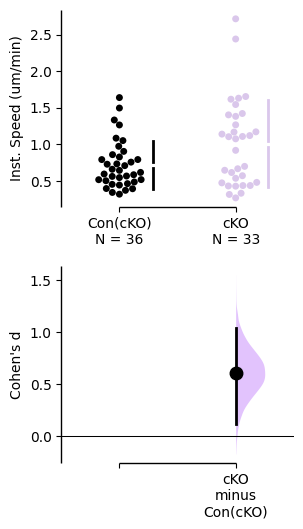

In [175]:
color_pal={'Con(cKO)':'black', 'cKO': '#dbb5fd'}
cKO_unpaired_speed.cohens_d.plot(swarm_label='Inst. Speed (um/min)',float_contrast=False, custom_palette=color_pal, raw_marker_size=5);

In [150]:
cKO_DirRatio_Pair = pd.DataFrame([Single_Con_cKO_DirRatio_Last, Single_cKO_DirRatio_Last])
cKO_DirRatio_Pair = cKO_DirRatio_Pair.transpose()
cKO_DirRatio_Pair.rename(columns={0:"Con(cKO)", 1:"cKO"},inplace=True)
cKO_unpaired_DirRatio = dabest.load(cKO_DirRatio_Pair, idx=("Con(cKO)", "cKO"), resamples=5000)
cKO_unpaired_DirRatio.cohens_d

DABEST v0.3.1
             
Good afternoon!
The current time is Mon Mar 14 14:48:47 2022.

The unpaired Cohen's d between Con(cKO) and cKO is 0.125 [95%CI -0.372, 0.591].
The p-value of the two-sided permutation t-test is 0.607. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cohens_d.statistical_tests`

In [151]:
cKO_unpaired_DirRatio.cohens_d.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,Con(cKO),cKO,36,33,Cohen's d,False,0.12454,95,-0.372477,0.591342,0.607,0.612478,-0.509329,0.607023,-0.516763,0.7962,572.0


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:125: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



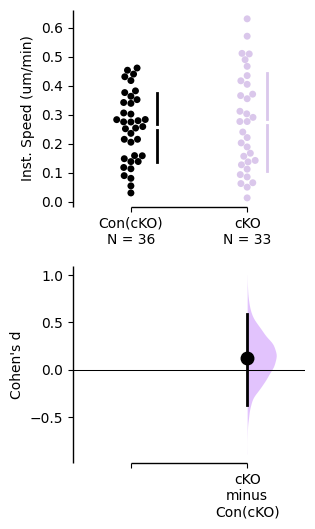

In [153]:
color_pal={'Con(cKO)':'black', 'cKO': '#dbb5fd'}
cKO_unpaired_DirRatio.cohens_d.plot(swarm_label='Inst. Speed (um/min)',float_contrast=False, custom_palette=color_pal, raw_marker_size=5);

In [181]:
time=[]
for i in range(len(Single_cKO_DirRatio_Mean)):
    time.append(i*5)

cKO_dirRatio_fig = go.Figure()

cKO_dirRatio_fig.add_trace(go.Scatter(x= time, y= Single_Con_cKO_DirRatio_All.mean(axis=1), name='Con(cKO)', line_color='#000000', error_y=dict(type='data', array = Single_Con_cKO_DirRatio_All.sem(axis=1), visible=True)))
cKO_dirRatio_fig.add_trace(go.Scatter(x= time, y= Single_cKO_DirRatio_All.mean(axis=1), name='cKO', line_color='#6a0dad', error_y =dict(type='data', array = Single_cKO_DirRatio_All.sem(axis=1) , visible=True)))
cKO_dirRatio_fig.update_layout(title="Scratch Assay: Con v cKO Dir_Ratio", xaxis_title="Time (min)", yaxis_title="Dir Ratio", legend_title="Genotype")
cKO_dirRatio_fig.show()

In [183]:
time=[]
for i in range(200):
    time.append(i*5)

cKO_MSD_fig = go.Figure()

cKO_MSD_fig.add_trace(go.Scatter(x= time, y= Single_Con_cKO_MSD.mean(axis=1)[0:100], name='Con(cKO)', line_color='#000000', error_y=dict(type='data', array = Single_Con_cKO_MSD_SEM, visible=True)))
cKO_MSD_fig.add_trace(go.Scatter(x= time, y= Single_cKO_MSD.mean(axis=1)[0:100], name='cKO', line_color='#6a0dad', error_y =dict(type='data', array = Single_cKO_MSD_SEM , visible=True)))
cKO_MSD_fig.update_layout(title="Scratch Assay: Con v cKO MSD", xaxis_title="Time (min)", yaxis_title="MSD", legend_title="Genotype")
cKO_MSD_fig.show()

In [286]:
Single_cKO_DA_fig = go.Figure()

Single_cKO_DA_fig.add_trace(go.Scatter(x= time, y= np.nanmean(Single_Con_cKO_DA, axis=0)[0:10], name='Con(cKO)', line_color='#000000', error_y=dict(type='data', array = Single_Con_cKO_DA.sem(axis=0), visible=True)))
Single_cKO_DA_fig.add_trace(go.Scatter(x= time, y= np.nanmean(Single_cKO_DA, axis=0)[0:10], name='cKO', line_color='#6a0dad', error_y =dict(type='data', array = Single_cKO_DA.sem(axis=0) , visible=True)))
Single_cKO_DA_fig.update_layout(title="Scratch Assay: Con(cKO) v cKO Dir AutoCorr", xaxis_title="Time (min)", yaxis_title="Dir AutoCorr", legend_title="Condition")
Single_cKO_DA_fig.show()

In [237]:
first=[]
for i in range(np.shape(Single_cKO_VA)[0]):
    first.append(1)

Single_cKO_VA.insert(0, column='0', value=first)

ValueError: cannot insert 0, already exists

In [220]:
Single_cKO_VA_fig = go.Figure()

Single_cKO_VA_fig.add_trace(go.Scatter(x= time, y= Single_Con_cKO_VA.mean(axis=0), name='Con(cKO)', line_color='#000000', error_y=dict(type='data', array = Single_Con_cKO_VA.sem(axis=0), visible=True)))
Single_cKO_VA_fig.add_trace(go.Scatter(x= time, y= Single_cKO_VA.mean(axis=0), name='cKO', line_color='#6a0dad', error_y =dict(type='data', array = Single_cKO_VA.sem(axis=0) , visible=True)))
Single_cKO_VA_fig.update_layout(title="Scratch Assay: Con(cKO) v cKO Vel AutoCorr", xaxis_title="Time (min)", yaxis_title="Vel Auto", legend_title="Condition")
Single_cKO_VA_fig.show()

Format Matlab Cell Tracker Outputs for DiPer:

In [ ]:
save_name = '2022_02_02_359_363_364_CellTracker_DiPer_Formatted_DMSO_tdt'
folder_path = "D:/Jesse/DMSO_Tracks/"
fname = sorted(glob(os.path.join(folder_path, "*.xls")))
#print(fname)
all_df = pd.DataFrame(columns= ['Filename', ' Cell ID ', ' Frame number ', ' x-coordinate [pixel] ', ' y-coordinate [pixel] '])
for file in range(len(fname)):
    file_name = fname[file].split('\\')[-1]
    file_name = file_name.split('.')[0]
    file_type = file_name.split('_')[-1]
    trackdata_df = pd.read_excel(fname[file])
    trackdata_df['Filename']= file_name
    cols = trackdata_df.columns.tolist()
    new_index = [cols[-1], cols[3],cols[2],cols[1],cols[0]]
    track_dataframe = trackdata_df.reindex(columns=new_index)
    all_df = pd.concat([all_df,track_dataframe])
df_microns = all_df.copy()
df_microns[' x-coordinate [pixel] '] = df_microns[' x-coordinate [pixel] '].apply(lambda x: x*0.6481)
df_microns[' y-coordinate [pixel] '] = df_microns[' y-coordinate [pixel] '].apply(lambda x: x*0.6481)
df_microns.rename(columns={' x-coordinate [pixel] ':' x-coordinate [μm] ', ' y-coordinate [pixel] ':' y-coordinate [μm] '}, inplace=True)
df_microns.to_csv('D:/Jesse/'+save_name+'_Microns.csv')
all_df.to_csv('D:/Jesse/'+save_name+'_Pixels.csv')

Format for diper analysis from trackmate:

In [88]:
#this formats dataframe for diper analysis from trackmate

# folder_path = "F:/Jesse/cKO/cKO_XML_Trajectories/cKO/"
# folder_path = "F:/Jesse/cKO/cKO_XML_Trajectories/Con(cKO)/"

# folder_path = "F:/Jesse/GoF/GoF_XML_Trajectories/GoF_tracks"
# folder_path = "F:/Jesse/GoF/GoF_XML_Trajectories/Con_GoF_tracks"

# folder_path = "F:/Jesse/tdTomato+Drug/dmso_tracks/"
folder_path = "F:/Jesse/tdTomato+Drug/yoda1_tracks/"

fname = sorted(glob(os.path.join(folder_path, "*.xml")))
df = pd.DataFrame(columns= ['Filename', 'Track Index', 'Frame', 'X', 'Y', 'Z'])
for file in tqdm(range(len(fname)), position=0, leave=True):
    file_name = fname[file].split('\\')[-1]
    file_name = re.sub('_ScratchFast','',file_name)
    file_name = re.sub('_MMStack','',file_name)
    file_name = re.sub(' nuclei Binned_Tracks.xml','',file_name)
    track_xml_file = loadxmlTrajs(fname[file])
    all_dataframe = pd.DataFrame.from_dict(track_xml_file)
    all_tracks_dataframe = pd.DataFrame(all_dataframe.loc['trackData'])
    for index, track_data in all_tracks_dataframe.iterrows():
        track_instance = all_tracks_dataframe.loc[index, 'trackData']
        track_dataframe = pd.DataFrame(track_instance)
        track_dataframe['Filename']= file_name
        track_dataframe['Track Index']='Track_'+index
        track_dataframe.rename(columns={0:'Frame', 1:'X', 2:'Y', 3:'Z'}, inplace=True)
        cols = track_dataframe.columns.tolist()
        cols = cols[-3:]+cols[:-3]
        track_dataframe = track_dataframe.reindex(columns=cols)
        df = pd.concat([df,track_dataframe])
date = datetime.now().strftime("%Y_%m_%d_")
df.to_csv(f'{date}_Yoda1.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/17605/OneDrive/Documents/Jesse/2022_04_21_Yoda1.csv'

In [90]:
df.to_csv(f'{date}_Yoda1.csv')